In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import cv2
import seaborn as sb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from tqdm import tqdm
from tqdm import trange
import tensorflow as tf
from tensorflow import keras
from keras.applications import NASNetLarge
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import CSVLogger
import imutils
from matplotlib import pyplot as plt

In [2]:
#tf.__version__
print(keras.__version__)

2.11.0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1711377981662933085
xla_global_id: -1
]


In [4]:
def contorno_de_cerebro(imagen, mostrar=False):
    # Convierte la imagen a escala de grises y difumínala ligeramente
    grises = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    grises = cv2.GaussianBlur(grises, (5, 5), 0)

    # Umbraliza la imagen y realiza erosiones y dilataciones para eliminar ruido
    umbral = cv2.threshold(grises, 45, 255, cv2.THRESH_BINARY)[1]
    umbral = cv2.erode(umbral, None, iterations=2)
    umbral = cv2.dilate(umbral, None, iterations=2)

    # Encuentra los contornos en la imagen umbralizada y selecciona el contorno más grande
    contornos = cv2.findContours(umbral.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos = imutils.grab_contours(contornos)
    contorno_mas_grande = max(contornos, key=cv2.contourArea)

    # Encuentra los puntos extremos del contorno
    extIzquierdo = tuple(contorno_mas_grande[contorno_mas_grande[:, :, 0].argmin()][0])
    extDerecho = tuple(contorno_mas_grande[contorno_mas_grande[:, :, 0].argmax()][0])
    extSuperior = tuple(contorno_mas_grande[contorno_mas_grande[:, :, 1].argmin()][0])
    extInferior = tuple(contorno_mas_grande[contorno_mas_grande[:, :, 1].argmax()][0])

    # Recorta la nueva imagen utilizando los puntos extremos (izquierda, derecha, arriba, abajo)
    nueva_imagen = imagen[extSuperior[1]:extInferior[1], extIzquierdo[0]:extDerecho[0]]

    if mostrar:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(imagen)
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Imagen original')

        plt.subplot(1, 2, 2)
        plt.imshow(nueva_imagen)
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Imagen recortada')
        
        plt.show()

    return nueva_imagen

# Directorios de las imágenes de tumor y saludables
dir_tumor = r'D:\\Base_de_datos\\si'
dir_saludable = r'D:\\Base_de_datos\\no'

# Lista para almacenar las rutas de los archivos y las etiquetas
rutas = []
etiquetas = []

# Lista de directorios
dir_list = [dir_tumor, dir_saludable]

# Recorrer los directorios y obtener las rutas de los archivos y las etiquetas
for i, directorio in enumerate(dir_list):
    lista_archivos = os.listdir(directorio)
    for archivo in lista_archivos:
        ruta_archivo = os.path.join(directorio, archivo)
        rutas.append(ruta_archivo)
        if i == 0:
            etiquetas.append('Tumor')
        else:
            etiquetas.append('Saludable')

# Crear Series de pandas con las rutas de los archivos y las etiquetas
serie_rutas = pd.Series(rutas, name='ruta del archivo')
serie_etiquetas = pd.Series(etiquetas, name='etiqueta')

# Concatenar las Series en un DataFrame
df = pd.concat([serie_rutas, serie_etiquetas], axis=1)
df.head()



,ruta del archivo,etiqueta
0,D:\\Base_de_datos\\si\Y1.png,Tumor
1,D:\\Base_de_datos\\si\Y10.png,Tumor
2,D:\\Base_de_datos\\si\Y100.png,Tumor
3,D:\\Base_de_datos\\si\Y1000.png,Tumor
4,D:\\Base_de_datos\\si\Y1001.png,Tumor


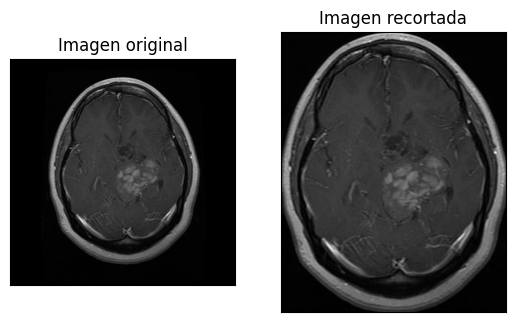

In [5]:
ex_img = cv2.imread('D:\Base_de_datos\si\Y1.png')
ex_new_img = contorno_de_cerebro(ex_img, True)

<Axes: xlabel='etiqueta', ylabel='count'>

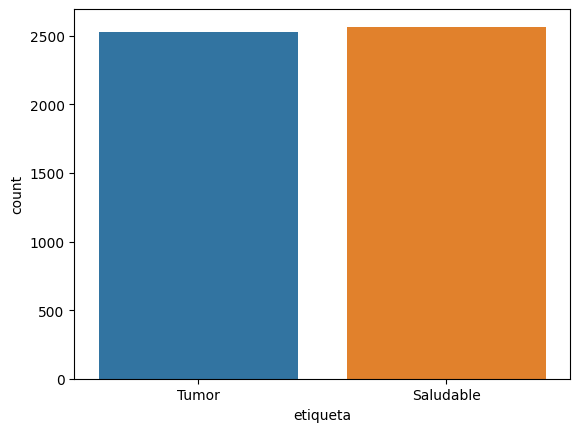

In [6]:
sb.countplot(data=df, x='etiqueta')

In [7]:
def codificador_columna(columna):
    if columna[0]=='Saludable':
        return 0
    else:
        return 1
df['etiqueta']=df[['etiqueta']].apply(codificador_columna, axis=1)

In [8]:
train_split=0.8
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=314)
test_df, val_df=train_test_split(dummy_df, train_size=0.5, shuffle=True)
print ('Entrenamiento_df: ', len(train_df), ' test_df: ', len(test_df), 
       ' validacion_df: ', len(val_df))


Entrenamiento_df:  4076  test_df:  510  validacion_df:  510


In [9]:
alto=331
ancho=331
channels=3
batch_size=40
img_tamaño=(alto, ancho)
Xtrain=[]
Ytrain=[]

for i in tqdm(range(len(train_df))):
    image=Image.open(train_df.iloc[i][0]).convert('RGB')
    image=image.resize(img_tamaño)
    data=np.asarray(image, dtype=float)
    Xtrain.append(np.array(data/255., dtype=float))
    Ytrain.append(np.array(train_df.iloc[i][1]))
     
#Leemos val_df
Xval=[]
Yval=[]
for i in tqdm(range(len(val_df))):
    image=Image.open(val_df.iloc[i][0]).convert('RGB')
    image=image.resize(img_tamaño)
    data=np.asarray(image, dtype=float)
    Xval.append(np.array(data/255., dtype=float))
    Yval.append(np.array(val_df.iloc[i][1]))
    

#Leemos train_df
Xtest=[]
Ytest=[]
for i in tqdm(range(len(test_df))):
    image=Image.open(test_df.iloc[i][0]).convert('RGB')
    image=image.resize(img_tamaño)
    data=np.asarray(image, dtype=float)
    Xtest.append(np.array(data/255., dtype=float))
    Ytest.append(np.array(test_df.iloc[i][1]))

100%|██████████| 510/510 [00:15<00:00, 33.89it/s]


In [10]:
Ytrain=np.array(Ytrain, dtype=float)
Yval=np.array(Yval, dtype=float)
Ytest=np.array(Ytest, dtype=float)
Xtrain= np.array(Xtrain, dtype=float)
Xval= np.array(Xval, dtype=float)
Xtest= np.array(Xtest, dtype=float)

In [11]:
#Cargamos el modelo pre-entrenado NasNetLarge sin la última capa
model=NASNetLarge(include_top=False, input_shape=(alto, ancho, channels))

In [12]:
#Congelamos todas las capas del modelo
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

In [13]:
#Añadimos una última capa densa de 250 neuronas
model4=tf.keras.models.Sequential([
    model, 
    Flatten(),
    Dense(250, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
# summarize
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 flatten (Flatten)           (None, 487872)            0         
                                                                 
 dense (Dense)               (None, 250)               121968250 
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                                 
Total params: 206,885,319
Trainable params: 121,968,501
Non-trainable params: 84,916,818
_________________________________________________________________


In [14]:
model4.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])

In [15]:
csv_logger = CSVLogger("corte_registro_con_ultima_250", append=True)

In [16]:
with tf.device("/device:GPU:0"):
    model4.fit(Xtrain, Ytrain, epochs=10, validation_data=(Xval, Yval), verbose=1,
        shuffle=True, batch_size=40, callbacks=[csv_logger])

Epoch 1/10
102/102 [==============================] - 2427s 23s/step - loss: 0.2374 - binary_accuracy: 0.8965 - val_loss: 0.1388 - val_binary_accuracy: 0.9490
Epoch 2/10
102/102 [==============================] - 2330s 23s/step - loss: 0.0498 - binary_accuracy: 0.9865 - val_loss: 0.0428 - val_binary_accuracy: 0.9902
Epoch 3/10
102/102 [==============================] - 2325s 23s/step - loss: 0.0192 - binary_accuracy: 0.9978 - val_loss: 0.0495 - val_binary_accuracy: 0.9863
Epoch 4/10
102/102 [==============================] - 2334s 23s/step - loss: 0.0105 - binary_accuracy: 0.9983 - val_loss: 0.0289 - val_binary_accuracy: 0.9922
Epoch 5/10
102/102 [==============================] - 2328s 23s/step - loss: 0.0055 - binary_accuracy: 1.0000 - val_loss: 0.0263 - val_binary_accuracy: 0.9922
Epoch 6/10
102/102 [==============================] - 2323s 23s/step - loss: 0.0031 - binary_accuracy: 1.0000 - val_loss: 0.0213 - val_binary_accuracy: 0.9922
Epoch 7/10
102/102 [==========================

In [17]:
model4.save('si_no_corte.h5')

In [18]:
history = model4.history.history

In [19]:
for key in history.keys():
    print(key)

loss
binary_accuracy
val_loss
val_binary_accuracy


In [20]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['binary_accuracy']
    val_acc = history['val_binary_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

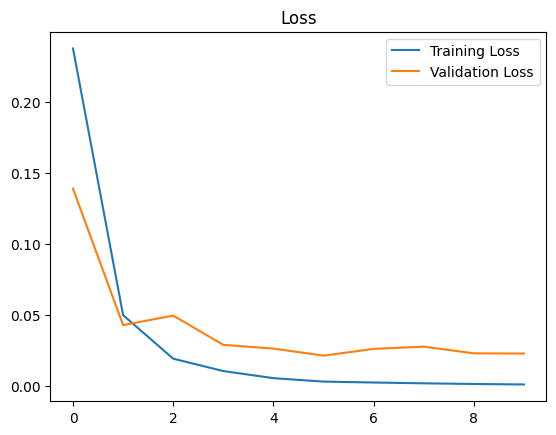

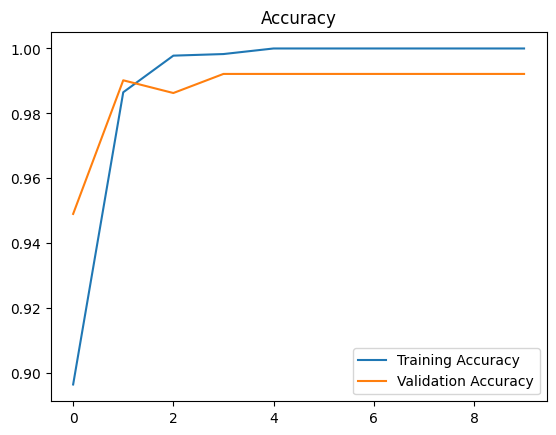

In [21]:
plot_metrics(history) 

In [22]:
def to_categorical(arr):
    for i in trange(len(arr)):
        if arr[i]<0.5:
            arr[i]=0
        else:
            arr[i]=1
    return arr  

16/16 [==============================] - 253s 15s/step


100%|██████████| 510/510 [00:00<00:00, 170174.63it/s]


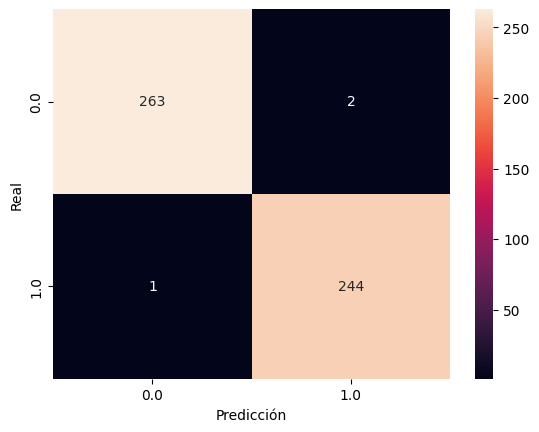

In [23]:
#Matriz de Confusión
Y=model4.predict(Xtest)
Y=np.array(Y.flatten())
Y=to_categorical(Y)
confusion_matrix = pd.crosstab(Ytest, Y, rownames=['Real'], colnames=['Predicción'])

sb.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [24]:
from sklearn.metrics import classification_report
cl=classification_report(Ytest, Y)
print(cl)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       265
         1.0       0.99      1.00      0.99       245

    accuracy                           0.99       510
   macro avg       0.99      0.99      0.99       510
weighted avg       0.99      0.99      0.99       510

